**Business Case:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing Skin Cancer Data**

To do: Take necessary actions to read the data

In [1]:
# importing necessary libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Extracting files to local environment

#!unzip '/content/gdrive/MyDrive/CNN_assignment.zip' -d '/content/gdrive/MyDrive/CNN_assignment/'

In [4]:
# Defining the path for train and test images
# Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
!ls

gdrive	sample_data


In [6]:
# Count of images in train and test datasets

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


So we have 2357 images in the dataset of 9 types of skin cancer.
The dataset contains 9 sub-directories in each train and test subdirectories and these 9 sub-directories contains the images of 9 skin cancer types.

**Create a dataset**

Define some parameters for the loader:

In [7]:
# Specifying input dimensions of each dimension

batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% of images for validation.

In [8]:
# Write your train dataset here
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed = 123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Write your validation dataset here
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
# data type of training data set

print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [12]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))  

32
32


**Visualize the data**

Todo, create a code to visualize one instance of all the nine classes present in the dataset

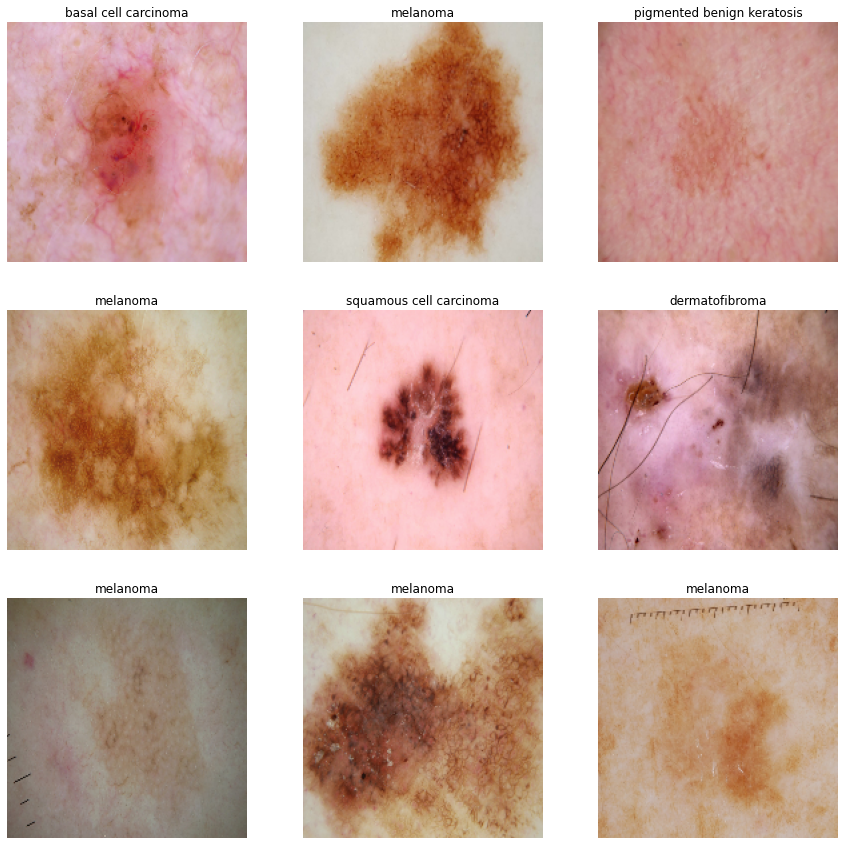

In [13]:
# Visualizing one instance of all nine classes present in the dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(10):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [14]:
# AUTOTUNE overlaps data preprocessing and model execution while training and speeds up training

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

**Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]**

In [15]:
### Your code goes here
num_classes = 9

# Using Sequential model as it is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # 2D convolution layer - To slide over the feature map and extract tiles of a specified size. 
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  # To slide over the feature map and extract tiles of a specified size
  # To Downsample the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  # Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting 
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  # Using Flattening to convert into 1D feature vector. It Flattens all its structure to create a single long feature vector
  # Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  # Using Dense layer for activation as it is fully connected layer where each node is connected to every node in the subsequent hidden layer.
  # It feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)

])


**Compile the model**

In [16]:
# View the summary of all layers

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [17]:
# Todo, choose an appropirate optimiser and loss function

# Using 'Adam' optimizer which uses estimations of the first and second moments of the gradient to adapt the learning rate for each weight of the neural network.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# Fitting model

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 558s 3s/step - loss: 2.0605 - accuracy: 0.2065 - val_loss: 2.0371 - val_accuracy: 0.2170
Epoch 2/20
56/56 [==============================] - 61s 1s/step - loss: 1.7977 - accuracy: 0.3510 - val_loss: 1.6724 - val_accuracy: 0.3602
Epoch 3/20
56/56 [==============================] - 60s 1s/step - loss: 1.5223 - accuracy: 0.4782 - val_loss: 1.4163 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 59s 1s/step - loss: 1.3628 - accuracy: 0.5268 - val_loss: 1.3883 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 61s 1s/step - loss: 1.3103 - accuracy: 0.5446 - val_loss: 1.5041 - val_accuracy: 0.4631
Epoch 6/20
56/56 [==============================] - 58s 1s/step - loss: 1.2310 - accuracy: 0.5681 - val_loss: 1.3840 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 58s 1s/step - loss: 1.1433 - accuracy: 0.5971 - val_loss: 1.4989 - val_accuracy: 0.5257
Epoch 8/20
56/56 [=

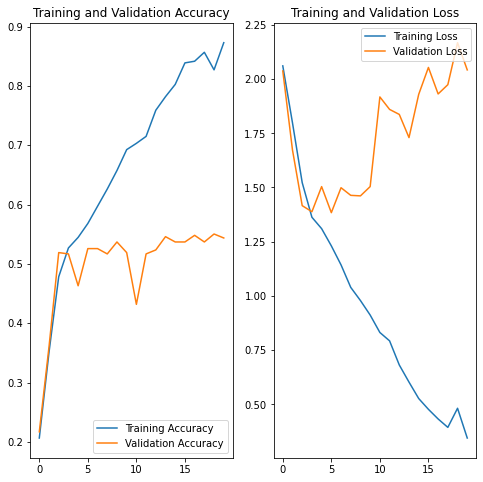

In [19]:
# Visualizing the results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Results** : 
  - Training Accuracy is 85% and Validation Accuracy is 55%
  - This shows that model is Overfitting.

**Using Data Augmentation to remove Overfitting**

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

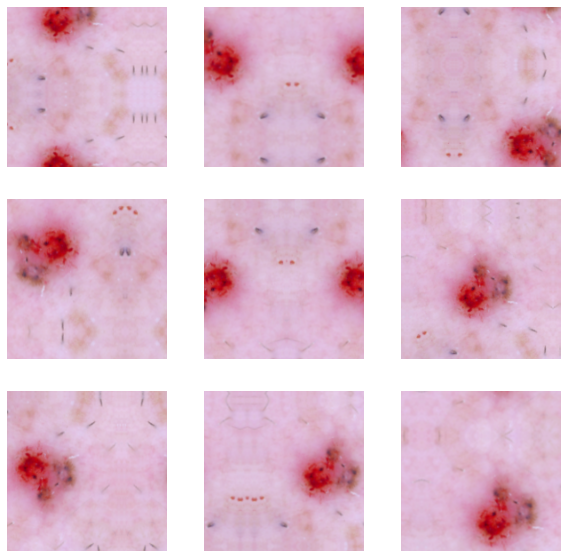

In [21]:
# Visualizing how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Create the model, compile and train the model after Augmentation**

In [22]:
# Creating Sequential model

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [23]:
# Compiling the model using Adam optimizer

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
## Your code goes here, note: train your model for 20 epochs
# Model fitting and evaluation

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 366s 6s/step - loss: 2.2000 - accuracy: 0.2321 - val_loss: 1.8032 - val_accuracy: 0.3445
Epoch 2/20
56/56 [==============================] - 359s 6s/step - loss: 1.7592 - accuracy: 0.3398 - val_loss: 1.6687 - val_accuracy: 0.3490
Epoch 3/20
56/56 [==============================] - 361s 6s/step - loss: 1.7224 - accuracy: 0.3510 - val_loss: 1.6287 - val_accuracy: 0.3870
Epoch 4/20
56/56 [==============================] - 358s 6s/step - loss: 1.6462 - accuracy: 0.3655 - val_loss: 1.6424 - val_accuracy: 0.4094
Epoch 5/20
56/56 [==============================] - 358s 6s/step - loss: 1.6408 - accuracy: 0.3795 - val_loss: 1.6218 - val_accuracy: 0.3893
Epoch 6/20
56/56 [==============================] - 360s 6s/step - loss: 1.6235 - accuracy: 0.3856 - val_loss: 1.6812 - val_accuracy: 0.3848
Epoch 7/20
56/56 [==============================] - 358s 6s/step - loss: 1.7353 - accuracy: 0.3527 - val_loss: 1.7678 - val_accuracy: 0.3177
Epoch 8/20
56/56 [======

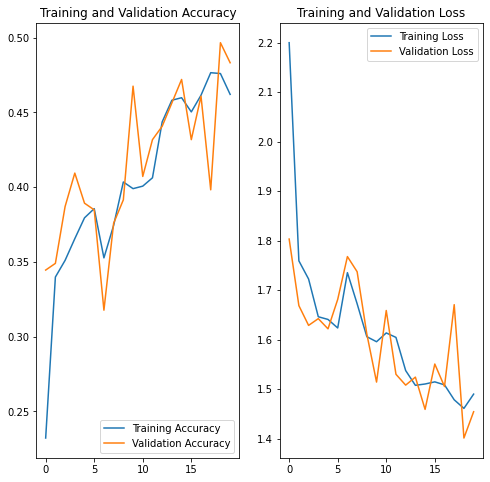

In [25]:
# Visualizing the results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Results:**

- Training accuracy is 46% and Validation accuracy is 48%
- The problem of Overfitting is resolved but model accuracy is very low.

In [26]:
# For convenience, let us set up the path for the training and validation sets
train_dir = os.path.join('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
val_dir = os.path.join('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224 

# Create training images generator which generates batches of tensor image data with real-time data augmentation.
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

# Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [28]:
#Creating a CNN model

import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=10
)


Epoch 1/10
23/23 [==============================] - 302s 13s/step - loss: 2.7750 - accuracy: 0.1912 - val_loss: 2.3331 - val_accuracy: 0.1356
Epoch 2/10
23/23 [==============================] - 183s 8s/step - loss: 2.0184 - accuracy: 0.2206 - val_loss: 2.2401 - val_accuracy: 0.2119
Epoch 3/10
23/23 [==============================] - 186s 8s/step - loss: 1.8450 - accuracy: 0.3216 - val_loss: 2.2871 - val_accuracy: 0.2119
Epoch 4/10
23/23 [==============================] - 185s 8s/step - loss: 1.6825 - accuracy: 0.3814 - val_loss: 2.0327 - val_accuracy: 0.3305
Epoch 5/10
23/23 [==============================] - 183s 8s/step - loss: 1.6547 - accuracy: 0.4140 - val_loss: 2.2910 - val_accuracy: 0.2881
Epoch 6/10
23/23 [==============================] - 181s 8s/step - loss: 1.6156 - accuracy: 0.4221 - val_loss: 2.2968 - val_accuracy: 0.3136
Epoch 7/10
23/23 [==============================] - 183s 8s/step - loss: 1.5018 - accuracy: 0.4757 - val_loss: 2.4213 - val_accuracy: 0.3051
Epoch 8/10
2

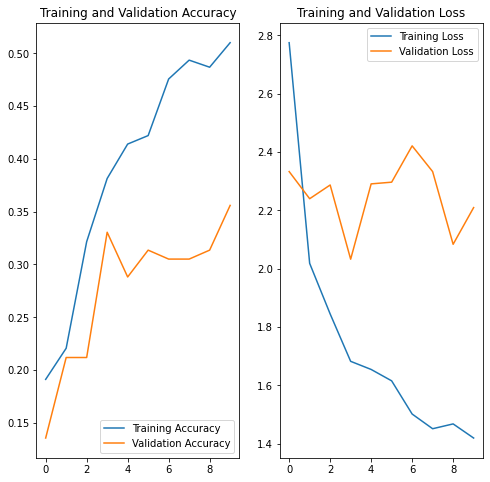

In [29]:
import matplotlib.pyplot as plt
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run? 
 - **There is little improvement than the previous model. However, model seems to be Overfitting because training accuracy is more than Validation accuracy.**

Todo: Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


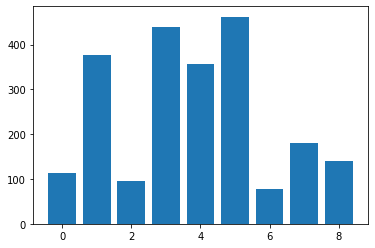

In [30]:
## Your code goes here.

from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

from sklearn.preprocessing import LabelEncoder
from collections import Counter

# split into input and output elements
X, y = original_df['Path'], original_df['Label']

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Todo: Write your findings here:
- Which class has the least number of samples? - **Actinic Keratosos and Seborrheic keratosis**
- Which classes dominate the data in terms proportionate number of samples? - **Pigmented benign keratosis dominates the data**

Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
# Setting Class Weights

from sklearn.utils import class_weight
#Class=0, n=114 (5.092%) - 400 = 500
#Class=1, n=376 (16.793%)  - 125
#Class=2, n=95 (4.243%) - 400
#Class=3, n=438 (19.562%) - 75
#Class=4, n=357 (15.945%) - 105
#Class=5, n=462 (20.634%)  -0
#Class=6, n=77 (3.439%) - 430
#Class=7, n=181 (8.084%) - 320
#Class=8, n=139 (6.208%) - 360 

class_weight = {0:5.09,
                1:16.79,
                2:4.24,
                3:19.56,
                4:15.94,
                5:20.63,
                6:3.43,
                7:8.08,
                8:6.20}

### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)

])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weight)


Epoch 1/20
56/56 [==============================] - 65s 1s/step - loss: 27.4410 - accuracy: 0.2015 - val_loss: 2.1230 - val_accuracy: 0.2260
Epoch 2/20
56/56 [==============================] - 72s 1s/step - loss: 24.2001 - accuracy: 0.2902 - val_loss: 1.8541 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 66s 1s/step - loss: 20.5322 - accuracy: 0.3945 - val_loss: 1.6310 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 60s 1s/step - loss: 18.1180 - accuracy: 0.4704 - val_loss: 1.6237 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 60s 1s/step - loss: 17.0802 - accuracy: 0.5061 - val_loss: 1.7102 - val_accuracy: 0.4407
Epoch 6/20
56/56 [==============================] - 59s 1s/step - loss: 16.7430 - accuracy: 0.5324 - val_loss: 1.4869 - val_accuracy: 0.5570
Epoch 7/20
56/56 [==============================] - 59s 1s/step - loss: 14.7700 - accuracy: 0.5670 - val_loss: 1.4450 - val_accuracy: 0.5369
Epoch 8/20
56

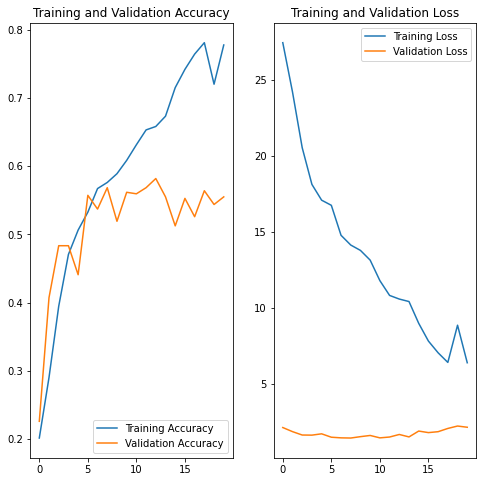

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Results:**
- Training Accuracy is 77% and Validation Accuracy is 55%. 
- Validation loss is very low.

**Using Data augmentation** - 

It is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.

In [33]:
# Installing Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## Adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB3C66E9F10>: 100%|██████████| 500/500 [00:27<00:00, 17.90 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB3C71BF1F0>: 100%|██████████| 500/500 [00:33<00:00, 14.74 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB3C67779A0>: 100%|██████████| 500/500 [00:26<00:00, 19.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB3C66A14F0>: 100%|██████████| 500/500 [01:54<00:00,  4.36 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FB3C666F490>: 100%|██████████| 500/500 [01:38<00:00,  5.05 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB3C66CCC10>: 100%|██████████| 500/500 [00:22<00:00, 21.96 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FB3C669A100>: 100%|██████████| 500/500 [01:02<00:00,  7.94 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB3C3D2E8E0>: 100%|██████████| 500/500 [00:29<00:00, 16.97 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB3C68BDB50>: 100%|██████████| 500/500 [00:25<00:00, 19.57 Samples/s]


In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [36]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_d8d12e28-3e11-4572-9060-8f55413a6b13.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_46f7693e-412c-4a89-8153-525b74929446.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_d7a220a8-e89c-412b-b0dd-81a331fabada.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_97fa0285-7a91-4348-9ff9-d77a6d9a5743.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. 

In [37]:
# Total count of augmented images.

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [38]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [40]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance.

**Training the model on the data created using Augmentor**

In [41]:
batch_size = 32
img_height = 180
img_width = 180

# Creating training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Creating Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Creating Model using Normalization
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compiling Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Training and Evaluation
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.
Epoch 1/20
169/169 [==============================] - 240s 1s/step - loss: 1.6864 - accuracy: 0.3620 - val_loss: 1.4896 - val_accuracy: 0.4254
Epoch 2/20
169/169 [==============================] - 184s 1s/step - loss: 1.3175 - accuracy: 0.5004 - val_loss: 1.3265 - val_accuracy: 0.5167
Epoch 3/20
169/169 [==============================] - 180s 1s/step - loss: 1.1040 - accuracy: 0.5885 - val_loss: 1.1118 - val_accuracy: 0.6006
Epoch 4/20
169/169 [==============================] - 184s 1s/step - loss: 0.8889 - accuracy: 0.6712 - val_loss: 0.9130 - val_accuracy: 0.6667
Epoch 5/20
169/169 [==============================] - 182s 1s/step - loss: 0.7171 - accuracy: 0.7422 - val_loss: 0.8669 - val_accuracy: 0.6941
Epoch 6/20
169/169 [==============================] - 180s 1s/step - loss: 0.5697 - accuracy: 0.7943 - val_loss: 0.7860 - val_accuracy: 0.7

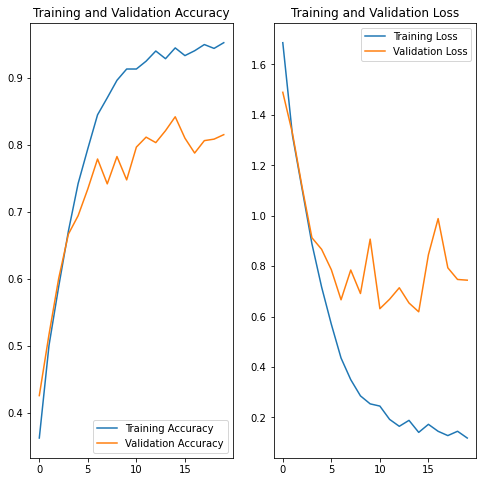

In [42]:
# Visualizing model reults

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion:**

- CNN model created with Training Accuracy of 95% and Validation accuracy of 81%.
- Training and Validation loss also decreased.